In [5]:
import pandas as pd

# Load the data from the uploaded CSV file
file_path = 'ab_test_data.csv'
ab_test_data = pd.read_csv(file_path)

# Display basic information about the dataset
ab_test_data.info(), ab_test_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     19998 non-null  object
 1   timestamp   19998 non-null  object
 2   test_group  19998 non-null  object
 3   conversion  19998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


(None,
                                 user_id                   timestamp  \
 0  7f6833e6-1141-4f20-b4b2-f1e31019b1fd  2023-07-04 04:40:55.848109   
 1  e6a6e960-d3f3-4074-a516-ba1e609b211e  2023-07-06 00:26:45.486187   
 2  4d3fbfa5-6847-410a-bac2-477f01d5f400  2023-07-10 20:24:33.639464   
 3  361457d9-a044-48f7-981c-d67dc3861679  2023-07-20 07:04:49.957013   
 4  285cd63d-7d03-427f-a062-1fa2dd2e77d6  2023-07-19 23:27:50.116680   
 
   test_group  conversion  
 0          a           0  
 1          b           0  
 2          b           0  
 3          b           0  
 4          b           0  )

**Data successfully read. The dataset contains the following columns:**

* user_id: A unique identifier for the user.
* timestamp: The time when the user performed an event.
* test_group: The group the user belongs to (A or B).
* conversion: Indicates whether the user made a conversion (1 - yes, 0 - no).

**Сalculate the key information regarding the A/B test:**

* Number of users in each group.
* Number of conversions in each group.
* Conversion rate in each group.
* Start and end dates of the test, as well as the test duration.

In [6]:
# Convert timestamp to datetime format for easier analysis
ab_test_data['timestamp'] = pd.to_datetime(ab_test_data['timestamp'])

# Calculate metrics
group_counts = ab_test_data['test_group'].value_counts()
conversion_counts = ab_test_data.groupby('test_group')['conversion'].sum()
conversion_rates = conversion_counts / group_counts
test_start_date = ab_test_data['timestamp'].min()
test_end_date = ab_test_data['timestamp'].max()
test_duration_days = (test_end_date - test_start_date).days

group_counts, conversion_counts, conversion_rates, test_start_date, test_end_date, test_duration_days


(test_group
 a    10013
 b     9985
 Name: count, dtype: int64,
 test_group
 a    611
 b    889
 Name: conversion, dtype: int64,
 test_group
 a    0.061021
 b    0.089034
 dtype: float64,
 Timestamp('2023-07-03 01:42:34.033708'),
 Timestamp('2023-07-25 01:41:19.152664'),
 21)

**A/B Test Analysis Results:**<br>**Number of Users:**<br>* Group A: 10,013 users.
* Group B: 9,985 users.
**Number of Conversions:**
* Group A: 611 conversions.
* Group B: 889 conversions.
**Conversion Rate:**
* Group A: 6.10%.
* Group B: 8.90%.
**Test Dates:**
* Start: July 3, 2023.
* End: July 25, 2023.
**Duration: 21 days.**

**The next step is to choose a statistical test for hypothesis testing and calculate the test statistic and p-value.**

In [8]:
from scipy.stats import chi2_contingency

# Create a contingency table for the chi-squared test
contingency_table = [
    [conversion_counts['a'], group_counts['a'] - conversion_counts['a']],
    [conversion_counts['b'], group_counts['b'] - conversion_counts['b']]
]

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
chi2_stat, p_value


(np.float64(56.14249485320227), np.float64(6.740440730497395e-14))

**Statistical Test Results:**

* Chi-squared (χ²) statistic: 56.14
* P-value: 6.74 × 10⁻¹⁴
Since the p-value is significantly less than 0.05, we can reject the null hypothesis. This means there is a statistically significant difference in conversion rates between groups A and B.

**Сalculate daily conversion rates**

In [11]:
ab_test_data['date'] = ab_test_data['timestamp'].dt.date
daily_summary = ab_test_data.groupby(['date', 'test_group'])['conversion'].agg(['sum', 'count']).reset_index()
daily_summary['conversion_rate'] = daily_summary['sum'] / daily_summary['count']

**Pivot the data for plotting**

In [12]:
daily_pivot = daily_summary.pivot(index='date', columns='test_group', values='conversion_rate')

**Save the results for visualization and report creation**

In [13]:
daily_pivot.head(), conversion_rates, test_start_date, test_end_date, test_duration_days

(test_group         a         b
 date                          
 2023-07-03  0.050971  0.087640
 2023-07-04  0.065022  0.081858
 2023-07-05  0.064220  0.083151
 2023-07-06  0.054705  0.095918
 2023-07-07  0.075472  0.075949,
 test_group
 a    0.061021
 b    0.089034
 dtype: float64,
 Timestamp('2023-07-03 01:42:34.033708'),
 Timestamp('2023-07-25 01:41:19.152664'),
 21)

**Сonversion rate over time chart**

'/mnt/data/daily_conversion_rates.png'

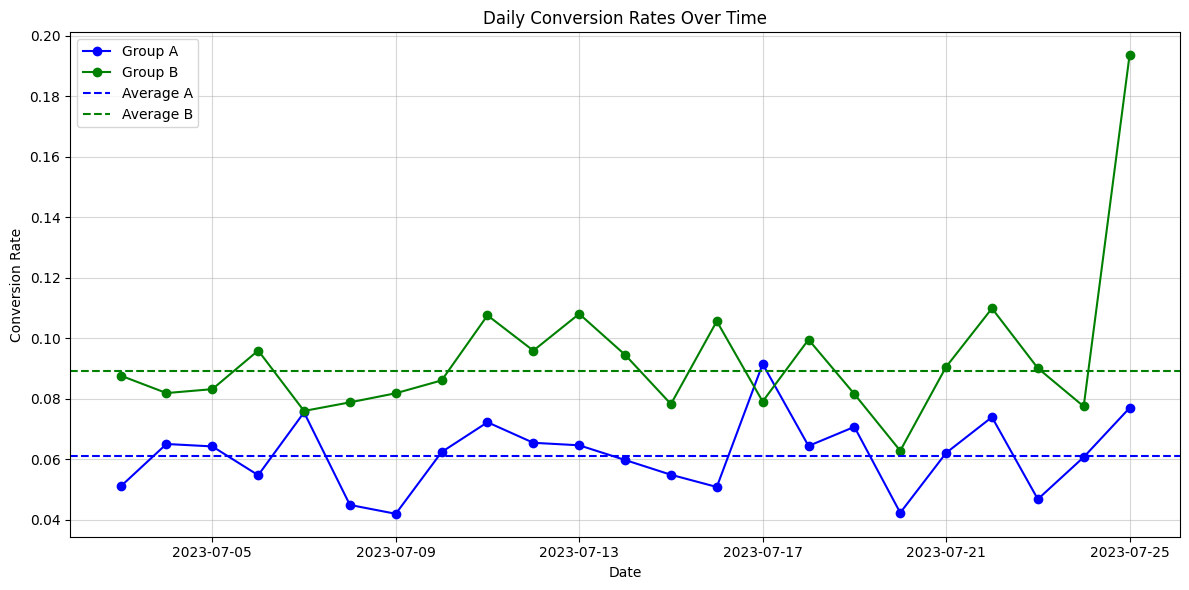

In [15]:
import matplotlib.pyplot as plt

# Plot daily conversion rates
plt.figure(figsize=(12, 6))
plt.plot(daily_pivot.index, daily_pivot['a'], label='Group A', marker='o', linestyle='-', color='blue')
plt.plot(daily_pivot.index, daily_pivot['b'], label='Group B', marker='o', linestyle='-', color='green')
plt.axhline(conversion_rates['a'], color='blue', linestyle='--', label='Average A')
plt.axhline(conversion_rates['b'], color='green', linestyle='--', label='Average B')
plt.title('Daily Conversion Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

plot_path

**Bar Chart of Conversion Rates: A simple bar chart comparing the conversion rates of Group A and Group B.**

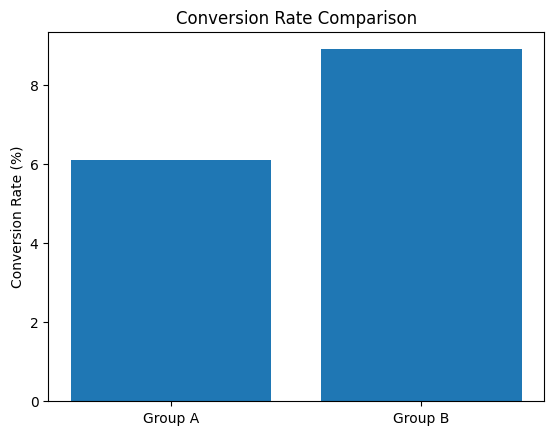

In [16]:
groups = ['Group A', 'Group B']
conversion_rates = [6.10, 8.90]

plt.bar(groups, conversion_rates)
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate Comparison')
plt.show()

**Bar Chart of Number of Conversions: A bar chart showing the total number of conversions for each group.**

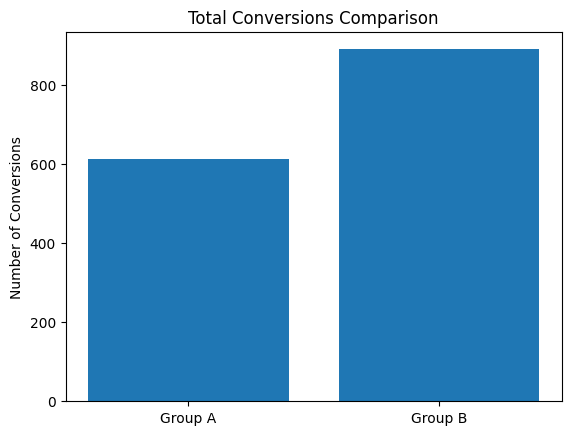

In [17]:
groups = ['Group A', 'Group B']
conversions = [611, 889]

plt.bar(groups, conversions)
plt.ylabel('Number of Conversions')
plt.title('Total Conversions Comparison')
plt.show()

**Lift Chart: This visualization shows the percentage lift in conversion rate achieved by the treatment group compared to the control group.**

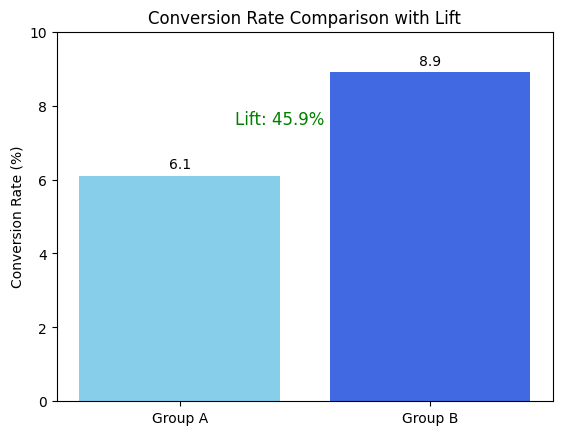

In [25]:
groups = ['Group A', 'Group B']
conversion_rates = [6.10, 8.90]
lift = ((8.90 - 6.10) / 6.10) * 100

plt.bar(groups, conversion_rates, color=['skyblue', 'royalblue'])
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate Comparison with Lift')
plt.ylim(0, 10)
plt.text(0.4, 7.5, f'Lift: {lift:.1f}%', ha='center', fontsize=12, color='green') # Аннотация
for i, v in enumerate(conversion_rates):
    plt.text(i, v + 0.2, str(v), ha='center')
plt.show()